# Data Loading/Prep

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
from tqdm.notebook import tqdm
# stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danielvangelde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
TEST_BODIES_PATH = "data/fnc-1/competition_test_bodies.csv"
TEST_STANCES_PATH = "data/fnc-1/competition_test_stances.csv"
TRAIN_BODIES_PATH = "data/fnc-1/train_bodies.csv"
TRAIN_STANCES_PATH = "data/fnc-1/train_stances.csv"
ALBERT_PREDICTIONS = "data/fnc-1/golden_labels_2.csv"
BASELINE_PREDICTIONS = "data/fnc-1/baseline_output.csv"


In [3]:
def create_merged_df(bodies_path, stances_path):
    bodies = pd.read_csv(bodies_path, names=['Body ID', 'articleBody'], header=0)
    stances = pd.read_csv(stances_path, names=['Headline', 'Body ID', 'Stance'], header=0)
    df = pd.merge(bodies, stances, on='Body ID')
    return df


albert = pd.read_csv(ALBERT_PREDICTIONS, names=['Headline', 'Body ID', 'Stance'], header=0)
baseline = pd.read_csv(BASELINE_PREDICTIONS, names=['Headline', 'Body ID', 'Stance'], header=0)
baseline.columns = ['Headline', 'Body ID', 'Stance_baseline']
test_res = create_merged_df(TEST_BODIES_PATH, TEST_STANCES_PATH)
# test_res['albert'] = pd.malbert[['Headline', 'Stance']]
test_res = pd.merge(test_res,albert, on=['Headline', 'Body ID'], suffixes=['_true', '_albert'])
test_res = pd.merge(test_res,baseline, on=['Headline', 'Body ID'])
train = create_merged_df(TRAIN_BODIES_PATH, TRAIN_STANCES_PATH)
display(test_res)
display(train)

,Body ID,articleBody,Headline,Stance_true,Stance_albert,Stance_baseline
0,1,Al-Sisi has denied Israeli reports stating tha...,Apple installing safes in-store to protect gol...,unrelated,unrelated,unrelated
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,agree,discuss
2,1,Al-Sisi has denied Israeli reports stating tha...,Apple to keep gold Watch Editions in special i...,unrelated,unrelated,unrelated
3,1,Al-Sisi has denied Israeli reports stating tha...,Apple Stores to Keep Gold “Edition” Apple Watc...,unrelated,unrelated,unrelated
4,1,Al-Sisi has denied Israeli reports stating tha...,South Korean woman's hair 'eaten' by robot vac...,unrelated,unrelated,unrelated
...,...,...,...,...,...,...
26860,2586,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,agree,unrelated
26861,2586,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,disagree,discuss
26862,2586,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,disagree,unrelated
26863,2586,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,agree,unrelated


,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",unrelated
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,unrelated
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,unrelated
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,unrelated
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,unrelated
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",agree
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",agree
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",agree
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,agree


In [4]:
print("A few sanity checks:")
correct_agree_albert = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_albert'] == 'agree')].shape[0]
correct_agree_base = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_baseline'] == 'agree')].shape[0]
print(f"Amount of agrees, predicted by ALBERT as agree: {correct_agree_albert}")
print(f"Amount of agrees, predicted by baseline as agree: {correct_agree_base}")


agree_disagree_albert = test_res.loc[(test_res['Stance_true'] == 'agree') & (test_res['Stance_albert'] == 'disagree')].shape[0]
print(f"Amount of agrees, predicted by ALBERT as disagree: {agree_disagree_albert}")
correct_unrelated = test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_baseline'] == 'unrelated')].shape[0]
print(f"Amount of unrelated pairs, correctly predicted by baseline as unrelated: {correct_unrelated}")


def get_confusion_value(true_label, predicted_label):
    return test_res.loc[(test_res['Stance_true'] == true_label) & (test_res['Stance_albert'] == predicted_label)].shape[0]
confusion_matrix_albert = [[get_confusion_value('agree', 'agree'),get_confusion_value('agree', 'disagree'),get_confusion_value('agree', 'discuss'),get_confusion_value('agree', 'unrelated')],
             [test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'disagree') & (test_res['Stance_albert'] == 'unrelated')].shape[0]],
             [test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'discuss') & (test_res['Stance_albert'] == 'unrelated')].shape[0]],
             [test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'agree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'disagree')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'discuss')].shape[0],
            test_res.loc[(test_res['Stance_true'] == 'unrelated') & (test_res['Stance_albert'] == 'unrelated')].shape[0]]]
print(f"confusion matrix for ALBERT: {confusion_matrix_albert}")
print("WARNING: there seems to be a discrepancy")

A few sanity checks:
Amount of agrees, predicted by ALBERT as agree: 1120
Amount of agrees, predicted by baseline as agree: 191
Amount of agrees, predicted by ALBERT as disagree: 84
Amount of unrelated pairs, correctly predicted by baseline as unrelated: 18967
confusion matrix for ALBERT: [[1120, 84, 495, 306], [224, 177, 118, 178], [739, 153, 3338, 582], [85, 34, 218, 19014]]


In [5]:
test_headlines = set(test_res['Headline'].values)
train_count = 0
for headline in train['Headline'].values:
    if headline in test_headlines:
        train_count += 1

train_length = len(train['Headline'].values)
print(f"There are {train_count} train headlines that occur in the test set out of {train_length}")


train_headlines = set(train['Headline'].values)
test_count = 0
for headline in test_res['Headline'].values:
    if headline in train_headlines:
        test_count += 1
test_length = len(test_res['Headline'].values)
print(f'There are {test_count} test headlines that occur in the train set out of {test_length}')

print(f'We have {len(train_headlines)} unique train headlines and {len(test_headlines)}, the intersection has size {len(train_headlines.intersection(test_headlines))}')

There are 156 train headlines that occur in the test set out of 49972
There are 155 test headlines that occur in the train set out of 26865
We have 1648 unique train headlines and 894, the intersection has size 10


In [6]:
test_res_rel = test_res.loc[test_res['Stance_true'] != 'unrelated']
correct = test_res_rel.copy()
correct['correct_albert'] = test_res_rel['Stance_true'] == test_res_rel['Stance_albert']
correct['correct_base'] = test_res_rel['Stance_true'] == test_res_rel['Stance_baseline']
correct = correct[['articleBody', 'Headline', 'Stance_true', 'correct_albert', 'correct_base']]
display(correct)

,articleBody,Headline,Stance_true,correct_albert,correct_base
1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,True,False
34,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,True,False
107,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,True,True
201,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,True,True
208,GR editor’s Note\r\n\r\nThere are no reports i...,Iraqi Army Downs Two British Planes Carrying W...,discuss,True,True
...,...,...,...,...,...
26860,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,False,False
26861,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,False,False
26862,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,True,False
26863,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,False,False


In [7]:
correct_count = correct[['Headline', 'correct_albert', 'correct_base']].groupby(['Headline']).sum().sort_values('correct_albert', ascending=False)
correct_count.reset_index(level=0, inplace=True)
display(correct_count)

,Headline,correct_albert,correct_base
0,"Source: Joan Rivers' doc did biopsy, selfie",126,193
1,Charles Manson’s fiancee allegedly wanted to m...,81,81
2,Joan Rivers Personal Doctor Allegedly Took A S...,55,82
3,Disturbed aunt cuts off nephew’s penis after h...,41,41
4,Joan Rivers’ Doctor Snapped Selfie During Thro...,36,36
...,...,...,...
889,REPORT: ISIS FIGHTING JUST ONE MILE OUTSIDE BA...,0,5
890,REPORT: MARINES ORDERED BY STATE DEPT TO SURRE...,0,5
891,Apple Watch Digital Crown -- Could It Color Ad...,0,1
892,Angry Aunt Who Sliced Off Three-Year-Old Nephe...,0,2


,articleBody,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
0,New information is coming out about the events...,46,46,1,1,47,0.978723,0.978723,0
1,More details are emerging in the death of Joan...,44,36,1,9,45,0.977778,0.800000,8
2,The comedienne's doctor reportedly took a self...,41,41,1,1,42,0.976190,0.976190,0
3,Details surrounding the death of comedian Joan...,41,41,2,2,43,0.953488,0.953488,0
4,Joan Rivers. Photo: AP\r\n\r\nJoan Rivers' per...,39,39,1,1,40,0.975000,0.975000,0
...,...,...,...,...,...,...,...,...,...
895,President Donald Trump has reportedly told mul...,0,1,6,5,6,0.000000,0.166667,-1
896,President Trump has privately told multiple pe...,0,1,6,5,6,0.000000,0.166667,-1
897,"President Trump has told multiple people, incl...",0,1,6,5,6,0.000000,0.166667,-1
898,President Trump's son-in-law and now top White...,0,0,6,6,6,0.000000,0.000000,0


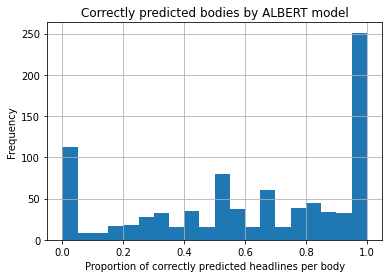

In [8]:
grouped_bodies = correct[['articleBody', 'correct_albert', 'correct_base']].groupby(['articleBody']).sum().sort_values('correct_albert', ascending=False)
grouped_bodies.reset_index(level=0, inplace=True)

pair_count = {}
rel_bodies = set(grouped_bodies['articleBody'].values)
# print(rel_headlines)
for body in rel_bodies:
    pair_count[body] = test_res_rel.loc[test_res_rel['articleBody'] == body].shape[0]

missed_count_albert = []
missed_count_base = []
total = []

for body in grouped_bodies['articleBody'].values:
    total.append(pair_count[body])
    missed_count_albert.append(pair_count[body] - grouped_bodies.loc[grouped_bodies['articleBody'] == body]['correct_albert'].values[0])
    missed_count_base.append(pair_count[body] - grouped_bodies.loc[grouped_bodies['articleBody'] == body]['correct_base'].values[0])
     
grouped_bodies['missed_albert'] = missed_count_albert
grouped_bodies['missed_base'] = missed_count_base
grouped_bodies['total'] = total
grouped_bodies['prop_albert'] = grouped_bodies['correct_albert'] / grouped_bodies['total']
grouped_bodies['prop_base'] = grouped_bodies['correct_base'] / grouped_bodies['total']

grouped_bodies['difference'] = grouped_bodies['correct_albert'] - grouped_bodies['correct_base']
display(grouped_bodies)
hist_range = [0,1]
plt.hist(grouped_bodies['prop_albert'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted bodies by ALBERT model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted headlines per body')
plt.savefig('prop_albert.pdf')
plt.show()

In [9]:
print(f"Mean correct albert: {correct_count['correct_albert'].mean()}")
print(f"Mean correct base: {correct_count['correct_base'].mean()}")

Mean correct albert: 5.184563758389261
Mean correct base: 4.557046979865772


In [10]:
pair_count = {}
rel_headlines = set(test_res_rel['Headline'].values)
# print(rel_headlines)
for head in rel_headlines:
    pair_count[head] = test_res_rel.loc[test_res_rel['Headline'] == head].shape[0]
    
grouped_res = correct_count.copy()
missed_count_albert = []
missed_count_base = []
total = []

for headline in grouped_res['Headline'].values:
    total.append(pair_count[headline])
    missed_count_albert.append(pair_count[headline] - grouped_res.loc[grouped_res['Headline'] == headline]['correct_albert'].values[0])
    missed_count_base.append(pair_count[headline] - grouped_res.loc[grouped_res['Headline'] == headline]['correct_base'].values[0])
     
grouped_res['missed_albert'] = missed_count_albert
grouped_res['missed_base'] = missed_count_base
grouped_res['total'] = total

grouped_res['prop_albert'] = grouped_res['correct_albert'] / grouped_res['total']
grouped_res['prop_base'] = grouped_res['correct_base'] / grouped_res['total']

grouped_res['difference'] = grouped_res['correct_albert'] - grouped_res['correct_base']
display(grouped_res)
# display(grouped_res.loc[grouped_res['total'] > 20].sort_values('prop_albert', ascending=False))


,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
0,"Source: Joan Rivers' doc did biopsy, selfie",126,193,75,8,201,0.626866,0.960199,-67
1,Charles Manson’s fiancee allegedly wanted to m...,81,81,0,0,81,1.000000,1.000000,0
2,Joan Rivers Personal Doctor Allegedly Took A S...,55,82,35,8,90,0.611111,0.911111,-27
3,Disturbed aunt cuts off nephew’s penis after h...,41,41,16,16,57,0.719298,0.719298,0
4,Joan Rivers’ Doctor Snapped Selfie During Thro...,36,36,0,0,36,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...
889,REPORT: ISIS FIGHTING JUST ONE MILE OUTSIDE BA...,0,5,7,2,7,0.000000,0.714286,-5
890,REPORT: MARINES ORDERED BY STATE DEPT TO SURRE...,0,5,5,0,5,0.000000,1.000000,-5
891,Apple Watch Digital Crown -- Could It Color Ad...,0,1,1,0,1,0.000000,1.000000,-1
892,Angry Aunt Who Sliced Off Three-Year-Old Nephe...,0,2,9,7,9,0.000000,0.222222,-2


In [11]:
display(grouped_res[['Headline','difference','correct_albert','correct_base']].sort_values('difference', ascending=False))

,Headline,difference,correct_albert,correct_base
9,"Fake or freak? Woman, 21, claims to have paid ...",29,29,0
17,Florida woman gets third breast surgically imp...,18,27,9
30,Argentina's President Just Adopted a Son So He...,18,20,2
23,Argentina’s President Adopted A Jewish Godson ...,18,22,4
6,Saudi Arabia outlaws ‘tempting eyes’,17,33,16
...,...,...,...,...
458,A Russian Guy Says His Justin Bieber Ringtone ...,-16,3,19
479,This Woman Claims To Have Had Plastic Surgery ...,-17,3,20
121,Did Argentina's President Adopt A Jewish Baby ...,-19,10,29
2,Joan Rivers Personal Doctor Allegedly Took A S...,-27,55,82


In [12]:
display(grouped_res.sort_values(['prop_albert', 'total'], ascending=[True, False])[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
785,Woman Who Claimed To Have Surgery To Add Third...,0,11,32,21,32,0.0,0.343750,-11
772,‘Three-boobed’ woman: They’re not fake,0,0,30,30,30,0.0,0.000000,0
862,The Story of the 3-Boobed Lady Is As Fake As H...,0,5,27,22,27,0.0,0.185185,-5
800,Iraqi Army Downs 2 UK Planes Carrying Weapons ...,0,0,20,20,20,0.0,0.000000,0
783,Woman Gets Third Boob to Appear Unattractive t...,0,3,18,15,18,0.0,0.166667,-3
779,Woman Adds Third Breast by Undergoing Surgery ...,0,5,17,12,17,0.0,0.294118,-5
833,Doc calls macabre 'selfie' claims completely c...,0,0,17,17,17,0.0,0.000000,0
818,HP Is Planning To Split Into Two Separate Busi...,0,4,14,10,14,0.0,0.285714,-4
791,This Campaign Shows A Pretty Genius Way To Sto...,0,1,12,11,12,0.0,0.083333,-1
850,Sexually frustrated female owl killed male bec...,0,11,11,0,11,0.0,1.000000,-11


In [13]:
display(grouped_res.sort_values(['prop_base', 'total'], ascending=[True, False])[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
9,"Fake or freak? Woman, 21, claims to have paid ...",29,0,10,39,39,0.743590,0.0,29
61,Meet the 3-boobed woman,14,0,24,38,38,0.368421,0.0,14
632,Three Boobs Are Most Likely Two Boobs and a Lie,1,0,35,36,36,0.027778,0.0,1
772,‘Three-boobed’ woman: They’re not fake,0,0,30,30,30,0.000000,0.0,0
117,Adopting Potential Werewolves Is Routine Busin...,10,0,15,25,25,0.400000,0.0,10
800,Iraqi Army Downs 2 UK Planes Carrying Weapons ...,0,0,20,20,20,0.000000,0.0,0
100,No gender segregation on Saudia,11,0,8,19,19,0.578947,0.0,11
833,Doc calls macabre 'selfie' claims completely c...,0,0,17,17,17,0.000000,0.0,0
564,Crabzilla,2,0,14,16,16,0.125000,0.0,2
329,Triple-breasted woman pictured before 'operati...,5,0,9,14,14,0.357143,0.0,5


In [14]:
print(f"Average score for albert: {grouped_res['prop_albert'].mean()} (sigma = {grouped_res['prop_albert'].std()})")
print(f"Average score for baseline: {grouped_res['prop_base'].mean()} (sigma = {grouped_res['prop_base'].std()})")

Average score for albert: 0.6158226444199797 (sigma = 0.35992876692590525)
Average score for baseline: 0.5120076643342143 (sigma = 0.3888485233730106)


In [15]:
failed_count_albert = grouped_res.loc[grouped_res['prop_albert'] < 0.001].shape[0]
failed_count_base = grouped_res.loc[grouped_res['prop_base'] < 0.001].shape[0]
print(f"Amount of headlines where models failed completely: albert: {failed_count_albert}, base: {failed_count_base}")
succ_count_albert = grouped_res.loc[grouped_res['prop_albert'] > 0.999].shape[0]
succ_count_base = grouped_res.loc[grouped_res['prop_base'] > 0.999].shape[0]
print(f"Amount of headlines where models scored perfectly: albert: {succ_count_albert}, base: {succ_count_base}")

Amount of headlines where models failed completely: albert: 123, base: 196
Amount of headlines where models scored perfectly: albert: 279, base: 228


Amount of headlines that are outliers (larger than 50): 5


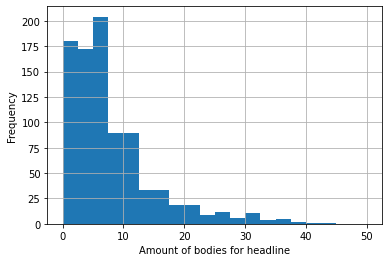

In [16]:
hist_range = [0, 50]
plt.hist(grouped_res['total'], bins=20, range=hist_range)
print(f"Amount of headlines that are outliers (larger than {hist_range[1]}): {grouped_res.loc[grouped_res['total'] > hist_range[1]].shape[0]}")
plt.grid()
plt.ylabel("Frequency")
plt.xlabel("Amount of bodies for headline")
plt.savefig('bodycount.pdf')
plt.show()

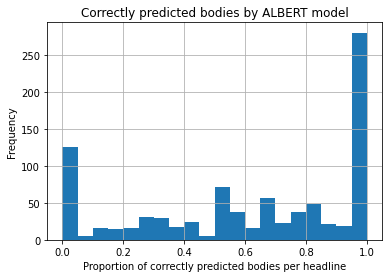

In [17]:
hist_range = [0,1]
plt.hist(grouped_res['prop_albert'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted bodies by ALBERT model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted bodies per headline')
plt.savefig('prop_albert.pdf')
plt.show()

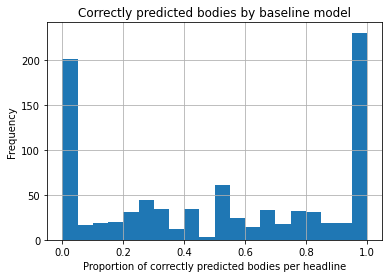

In [18]:
hist_range = [0,1]
plt.hist(grouped_res['prop_base'], bins=20, range=hist_range)
plt.grid()
plt.title("Correctly predicted bodies by baseline model")
plt.ylabel('Frequency')
plt.xlabel('Proportion of correctly predicted bodies per headline')
plt.savefig('prop_base.pdf')
plt.show()

In [19]:
correct_headlines_albert = set(grouped_res.loc[grouped_res['prop_albert'] > 0.99]['Headline'].values)
correct_headlines_base = set(grouped_res.loc[grouped_res['prop_base'] > 0.99]['Headline'].values)
failed_headlines_albert = set(grouped_res.loc[grouped_res['prop_albert'] < 0.01]['Headline'].values)
failed_headlines_base = set(grouped_res.loc[grouped_res['prop_base'] < 0.01]['Headline'].values)
print(f"Intersection size of set of correct headlines for albert ({len(correct_headlines_albert)}) and baseline ({len(correct_headlines_base)}): {len(correct_headlines_albert.intersection(correct_headlines_base))}")
print(f"Intersection size of set of failed headlines for albert ({len(failed_headlines_albert)}) and baseline ({len(failed_headlines_base)}): {len(failed_headlines_albert.intersection(failed_headlines_base))}")

Intersection size of set of correct headlines for albert (279) and baseline (228): 145
Intersection size of set of failed headlines for albert (123) and baseline (196): 56


In [20]:
punct = set(string.punctuation)
sw = stopwords.words('english')
punct.update(['`', '\'', '\'s', '’', '‘'])
stemmer = PorterStemmer()
def tokenize_corpus(corpus):
    token_dict = {}
    result = []
    tf = {}
    for passage in corpus:
        tokens = word_tokenize(passage)
        tokenized = []
        for token in tokens:
            token = token.lower()
            if token not in sw and token not in punct:
                stem = stemmer.stem(token)
                tokenized.append(stem)
                token_dict[stem] = token
                if stem not in tf.keys():
                    tf[stem] = 0
                tf[stem] += 1
        result.append(tokenized)
    return (result, token_dict, tf)

In [21]:
def sort_dict(x):
    return [(k, v) for k, v in sorted(x.items(), key=lambda item: item[1], reverse=True)]

tokenized_set, token_dict1, tf1 = tokenize_corpus(correct_headlines_albert)
word_dict_albert = {}
for stem in tf1.keys():
    word_dict_albert[token_dict1[stem]] = tf1[stem]
    
word_dict_albert = sort_dict(word_dict_albert)


tokenized_set, token_dict2, tf2 = tokenize_corpus(correct_headlines_base)
word_dict_base = {}
for stem in tf2.keys():
    word_dict_base[token_dict2[stem]] = tf2[stem]
    
word_dict_base = sort_dict(word_dict_base)

t=15

word_freq_albert = word_dict_albert[:t]
word_freq_base = word_dict_base[:t]
print(f"Top {t} frequent words in successfull headlines of ALBERT: {word_freq_albert}")
print(f"Top {t} frequent words in successfull headlines of Baseline: {word_freq_base}")

overlap = len(set([w[0] for w in word_freq_albert]).intersection(set([w[0] for w in word_freq_base]))) / t
print(f"The overlap of this top {t} is {overlap}")

Top 15 frequent words in successfull headlines of ALBERT: [('apple', 66), ('report', 60), ('watch', 34), ('isis', 27), ('reportedly', 20), ('rumor', 20), ('us', 17), ('airstrike', 15), ('may', 15), ('afghan', 15), ('kill', 14), ('saudi', 13), ('woman', 13), ('missing', 13), ('air', 13)]
Top 15 frequent words in successfull headlines of Baseline: [('apple', 75), ('report', 54), ('watch', 40), ('isis', 31), ('may', 17), ('joan', 17), ('rivers', 17), ('air', 17), ('rumor', 17), ('reportedly', 16), ('doctor', 16), ('selfie', 15), ('us', 13), ('beheading', 12), ('foley', 12)]
The overlap of this top 15 is 0.6


In [22]:

tokenized_set, token_dict1, tf1 = tokenize_corpus(failed_headlines_albert)
word_dict_albert = {}
for stem in tf1.keys():
    word_dict_albert[token_dict1[stem]] = tf1[stem]
    
word_dict_albert = sort_dict(word_dict_albert)


tokenized_set, token_dict2, tf2 = tokenize_corpus(failed_headlines_base)
word_dict_base = {}
for stem in tf2.keys():
    word_dict_base[token_dict2[stem]] = tf2[stem]
    
word_dict_base = sort_dict(word_dict_base)

t=15

word_freq_albert = word_dict_albert[:t]
word_freq_base = word_dict_base[:t]
print(f"Top {t} frequent words in failed headlines of ALBERT: {word_freq_albert}")
print(f"Top {t} frequent words in failed headlines of Baseline: {word_freq_base}")

overlap = len(set([w[0] for w in word_freq_albert]).intersection(set([w[0] for w in word_freq_base]))) / t
print(f"The overlap of this top {t} is {overlap}")

Top 15 frequent words in failed headlines of ALBERT: [('isis', 12), ('woman', 12), ('penis', 8), ('report', 8), ('us', 7), ('killed', 6), ('cat', 6), ('organs', 5), ('iraqi', 5), ('apple', 5), ('show', 5), ('airstrikes', 5), ('weapons', 5), ('way', 5), ('third', 5)]
Top 15 frequent words in failed headlines of Baseline: [('woman', 18), ('cat', 16), ('getting', 11), ('surgery', 11), ('eyes', 10), ('gender', 8), ('bill', 8), ('missing', 8), ('note', 8), ('show', 8), ('scorpion', 7), ('flights', 7), ('ferguson', 7), ('girl', 7), ('birthday', 7)]
The overlap of this top 15 is 0.2


In [23]:
display(grouped_res.loc[grouped_res['prop_albert'] < 0.001].sort_values('difference', ascending=True)[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
785,Woman Who Claimed To Have Surgery To Add Third...,0,11,32,21,32,0.0,0.343750,-11
850,Sexually frustrated female owl killed male bec...,0,11,11,0,11,0.0,1.000000,-11
884,President of Argentina adopts Jewish godson to...,0,9,10,1,10,0.0,0.900000,-9
853,APPLE WATCH MAY GO ON SALE IN MARCH ACCORDING ...,0,8,8,0,8,0.0,1.000000,-8
795,ISIS Might Be Harvesting Organs To Finance Ope...,0,7,10,3,10,0.0,0.700000,-7
807,British Jihadi Killed In US Airstrike - Reports,0,7,7,0,7,0.0,1.000000,-7
832,Here's What We Know About ISIS's Alleged Organ...,0,6,7,1,7,0.0,0.857143,-6
842,BOOK: CHARLES MANSON’S FIANCÉ WANTED MARRIAGE ...,0,6,6,0,6,0.0,1.000000,-6
871,"Argentina President, Christina Kirchner, Has B...",0,5,6,1,6,0.0,0.833333,-5
840,Crabzilla artist Quinton Winter reveals all af...,0,5,6,1,6,0.0,0.833333,-5


In [24]:
display(grouped_res.loc[grouped_res['prop_base'] < 0.001].sort_values('difference', ascending=False)[:10])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
9,"Fake or freak? Woman, 21, claims to have paid ...",29,0,10,39,39,0.743590,0.0,29
61,Meet the 3-boobed woman,14,0,24,38,38,0.368421,0.0,14
100,No gender segregation on Saudia,11,0,8,19,19,0.578947,0.0,11
117,Adopting Potential Werewolves Is Routine Busin...,10,0,15,25,25,0.400000,0.0,10
118,Ferguson protester shot in the eye with rubber...,10,0,2,12,12,0.833333,0.0,10
134,Evil Aunt Hacks Off Toddlers Penis,9,0,1,10,10,0.900000,0.0,9
199,‘I will have justice for what they did to me’:...,7,0,2,9,9,0.777778,0.0,7
204,Woman has surgery to get third breast: The thr...,7,0,6,13,13,0.538462,0.0,7
236,9-year-old girl pens touching letter to teache...,7,0,0,7,7,1.000000,0.0,7
275,The men caught cat-calling and wolf whistling ...,6,0,3,9,9,0.666667,0.0,6


In [25]:
display(test_res_rel)

,Body ID,articleBody,Headline,Stance_true,Stance_albert,Stance_baseline
1,1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,agree,discuss
34,2,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,agree,discuss
107,3,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,discuss,discuss
201,12,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,discuss,discuss
208,19,GR editor’s Note\r\n\r\nThere are no reports i...,Iraqi Army Downs Two British Planes Carrying W...,discuss,discuss,discuss
...,...,...,...,...,...,...
26860,2586,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,agree,unrelated
26861,2586,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,disagree,discuss
26862,2586,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,disagree,unrelated
26863,2586,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,agree,unrelated


In [55]:
tokenized_corpus = {}
bodies =  list(set(test_res_rel['articleBody'].values))
headlines = list(set(test_res_rel['Headline'].values))
corpus = bodies + headlines
for text in tqdm(corpus, total=len(corpus)):
    tokenized_corpus[text] = tokenize_corpus([text])[0][0]
    
print(len(tokenized_corpus))

  0%|          | 0/1794 [00:00<?, ?it/s]

1789


In [68]:
overlap = correct.copy()
overlap_values = []
i = 0
for (headline, body) in tqdm(overlap[['Headline', 'articleBody']].values, total=overlap.shape[0]):
        headline_token_set = set(tokenized_corpus[headline])
        body_token_set = set(tokenized_corpus[body])
        intersect = headline_token_set.intersection(body_token_set)
        union = headline_token_set.union(body_token_set)
        overl = len(intersect) / (len(headline_token_set))
#         if i < 2:
#             print("###########",i)
#             print(headline)
#             print(headline_token_set)
#             print(body)
#             print(body_token_set)
#             print(overl)
#             i += 1 
        overlap_values.append(overl)
overlap['overlap'] = overlap_values

  0%|          | 0/7514 [00:00<?, ?it/s]

In [69]:
display(overlap)

,articleBody,Headline,Stance_true,correct_albert,correct_base,overlap
1,Al-Sisi has denied Israeli reports stating tha...,El-Sisi denies claims he'll give Sinai land to...,agree,True,False,0.125000
34,A bereaved Afghan mother took revenge on the T...,Afghan Mother Kills 25 Taliban Fighters In Sev...,agree,True,False,0.916667
107,CNBC is reporting Tesla has chosen Nevada as t...,REPORT: Tesla Chooses Nevada For Site Of Its M...,discuss,True,True,0.625000
201,A 4-inch version of the iPhone 6 is said to be...,4-inch iPhone 6 reported to be in development,discuss,True,True,0.800000
208,GR editor’s Note\r\n\r\nThere are no reports i...,Iraqi Army Downs Two British Planes Carrying W...,discuss,True,True,0.900000
...,...,...,...,...,...,...
26860,Remember how much Republicans wanted to repeal...,A Sign That Obamacare Exchanges Are Failing,disagree,False,False,0.750000
26861,Remember how much Republicans wanted to repeal...,Republicans call Obamacare a 'failure.' These ...,agree,False,False,0.500000
26862,Remember how much Republicans wanted to repeal...,CBO’s Alternate Facts Show Obamacare is Unsust...,disagree,True,False,0.500000
26863,Remember how much Republicans wanted to repeal...,Why Obamacare failed,disagree,False,False,1.000000


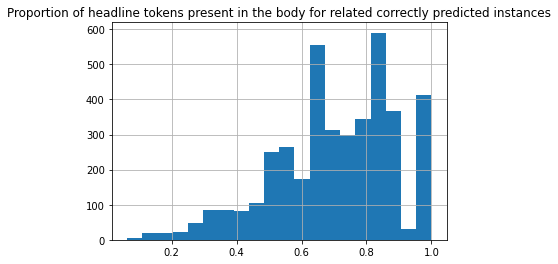

In [75]:
plt.hist(overlap.loc[overlap['correct_albert'] == True]['overlap'], bins = 20)
plt.title("Proportion of headline tokens present in the body for related correctly predicted instances (ALBERT)")
plt.grid()
plt.show()

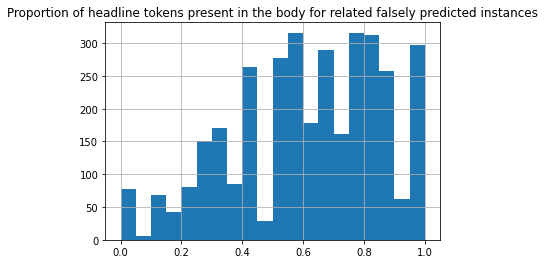

In [76]:
plt.hist(overlap.loc[overlap['correct_albert'] == False]['overlap'], bins = 20)
plt.title("Proportion of headline tokens present in the body for related falsely predicted instances (ALBERT)")
plt.grid()
plt.show()

In [ ]:
# falsely_agr = []
# falsely_dsc = []
# falsely_dsg = []
# for headline in grouped_res['Headline'].values:
#     instances = test_res_rel.loc[(test_res_rel['Headline'] == headline)]
#     falsely_agr.append(instances.loc[intance['Stance_albert']])

In [81]:
failed_bodies = grouped_bodies.loc[grouped_bodies['prop_albert'] < 0.001]['articleBody'].values
failed_headlines = grouped_res.loc[grouped_res['prop_albert'] < 0.001]['Headline'].values
instances_bodies_failed = test_res_rel.loc[test_res_rel['articleBody'].isin(failed_bodies)][['Headline', 'articleBody']]
instances_headlines_failed = test_res_rel.loc[test_res_rel['Headline'].isin(failed_headlines)][['Headline', 'articleBody']]
print(instances_bodies_failed.shape)
print(instances_headlines_failed.shape)

print(pd.merge(instances_bodies_failed, instances_headlines_failed).shape)

(486, 2)
(618, 2)
(96, 2)


In [167]:
example_body_row = grouped_bodies.loc[(grouped_bodies['prop_albert'] < 0.001) & (grouped_bodies['total'] > 5)].sample(n=1)
display(example_body_row)
print(f"Example Body:")
example_body = example_body_row['articleBody'].values[0]
print(example_body)
associated_headlines = test_res_rel.loc[test_res_rel['articleBody'] == example_body]['Headline'].values
print(f"Associated headlines n={len(associated_headlines)}:")
print(associated_headlines)

,articleBody,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
870,The White House has not directly addressed the...,0,5,6,1,6,0.0,0.833333,-5


Example Body:
The White House has not directly addressed the claim that they threatened Foley's family over ransom payments.
Associated headlines n=6:
['U.S. Officials Threatened James Foley’s Parents With Prosecution Over Ransom'
 'WH won’t say if Foley family was threatened not to pay ransom'
 "'They got in our way': James Foley's brother backs mother attacking Obama administration over failure to save photojournalist before he was beheaded by ISIS"
 'Would US sue parents of James Foley? Why White House is Defending Itself'
 'US denies it threatened Foley family'
 "James Foley's mother 'appalled' by U.S. government handling of case"]


In [175]:
example_headline_row = grouped_res.loc[(grouped_res['prop_albert'] < 0.001) & (grouped_res['total'] > 5)].sample(n=1)
display(example_headline_row)
print(f"Example Headline:")
example_headline = example_headline_row['Headline'].values[0]
print(example_headline)
associated_bodies = test_res_rel.loc[test_res_rel['Headline'] == example_headline]
print(f"Associated bodies n={associated_bodies.shape[0]}:")
display(associated_bodies[['articleBody', 'Stance_true', 'Stance_albert']])

,Headline,correct_albert,correct_base,missed_albert,missed_base,total,prop_albert,prop_base,difference
791,This Campaign Shows A Pretty Genius Way To Sto...,0,1,12,11,12,0.0,0.083333,-1


Example Headline:
This Campaign Shows A Pretty Genius Way To Stop Men Catcalling In The Street
Associated bodies n=12:


,articleBody,Stance_true,Stance_albert
5482,"This video has been hugely viral for months, b...",agree,discuss
6257,If you've ever wanted to tell a street harasse...,disagree,unrelated
6440,"Like most other places with people, Lima, Peru...",disagree,unrelated
8240,A new TV show in Peru has captured the moment ...,disagree,unrelated
9302,"The Peruvian TV show ""Harassing Your Mother"" p...",disagree,unrelated
10208,"""How nice pants"" (referring to the rear) is pr...",agree,discuss
13101,Peruvian Show ‘Whistling At Your Mom’ takes th...,disagree,unrelated
16245,A Peruvian public service announcement making ...,agree,discuss
18485,One tactic that should prevent overly hormonal...,agree,discuss
19259,Street harassment is something that happens to...,disagree,unrelated


# Intermezzo: corpus statistics

In [ ]:
TRAIN_BODIES_PATH = "data/fnc-1/train_bodies.csv"
TRAIN_STANCES_PATH = "data/fnc-1/train_stances.csv"

train_bodies = pd.read_csv(TRAIN_BODIES_PATH, names=['Body ID', 'articleBody'], header=0)
train_stances = pd.read_csv(TRAIN_STANCES_PATH, names=['Headline', 'Body ID', 'Stance'], header=0)


print("Num headlines:", len(set(stances['Headline'])) + len(set(train_stances['Headline'])))
print("Num bodies:", len(set(bodies['articleBody'])) + len(set(train_bodies['articleBody'])))
print("Num instances:", train_stances.shape[0] + stances.shape[0])

stance_count = {}
all_stances = np.concatenate((train_stances['Stance'].values, stances['Stance'].values))
for stance in all_stances:
    if stance not in stance_count.keys():
        stance_count[stance] = 0
    else:
        stance_count[stance] += 1
print(stance_count)
stance_freq = [count / len(all_stances) for count in stance_count.values()]
print(stance_freq)

In [ ]:

df['Predictions'] = albert['Stance']
df['Baseline'] = baseline['Stance']
display(df.sample(n=5))
print(df.shape)

In [ ]:
# Filter out only related pairs
df_rel = df.loc[df['Stance'] != 'unrelated']

display(df_rel.sample(n=5))
print(df_rel.shape)

# Data Transformation

In [ ]:
import nltk
import sklearn
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import string
import gensim
import gensim.downloader as api

# Download if not installed already
# nltk.download('stopwords')

In [ ]:
# load word2vec model
wv = api.load('word2vec-google-news-300')
# stopwords
nltk.download("stopwords")
sw = stopwords.words('english')
# punctuation
punct = set(string.punctuation)
# stemmer
stemmer = PorterStemmer()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
tfidf_matrix  = tf_vectorizer.fit_transform(df_rel['Headline'])
#importing LDAfrom gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation
#Fitting 
lda = LatentDirichletAllocation(n_components=100, learning_method='online', 
                                          random_state=0, verbose=0, n_jobs = -1)
lda_model = lda.fit(tfidf_matrix)
lda_matrix = lda_model.transform(tfidf_matrix)
lda_matrix.shape



In [ ]:
def print_topics(model, count_vectorizer, n_top_words):
    words = tf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx )
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))# Print the topics found by the LDA model

print("Topics found via LDA:")
print_topics(lda_model, df_rel['Headline'], 15)

In [ ]:
# embeddings = np.zeros((7064, 300))
# print(embeddings.shape)
# not_found = set([])
# for i, headline in tqdm(enumerate(df_rel['Headline'].values), total=len(df_rel['Headline'].values)):
#     tokens = word_tokenize(headline)
#     # Doc vec is average of summed word vectors
#     doc_vec = np.zeros(300)
#     n = len(tokens)
#     for token in tokens or token in sw:
#         if token in punct:
#             continue
#         try: 
#             vec = wv[token]
#             doc_vec += vec                
#         except KeyError: 
#             not_found.add(token)
        
#     doc_vec /= n
#     embeddings[i] = np.array(doc_vec)
#     print(embeddings[i])
#     break
# print(f'{len(not_found)} Tokens not found: {not_found}')
        
        
### Tokenization and lemmatization    
#     new_headline = []
#     for token in tokens:
#         token = token.lower()
#         if token not in punct and token not in sw:
#             new_headline.append(stemmer.stem(token))
#     tokenized_headlines.append(new_headline)
# 'th' means tokenized headlines
# print(embeddings.shape)
# df_rel['embeddings'] = embeddings
# display(df_rel[['Headline', 'embeddings']].sample(n=5))
# from sklearn.cluster import KMeans
# print(df_rel['embeddings'].values.shape)
# vector = np.vectorize(np.float64)
# X = df_rel['embeddings'].values
# for i, x in enumerate(X):
#     X[i] = vector(x)
# # print(df_rel['embeddings'].values.reshape(7064,300).shape)
# print(embeddings.shape)
# model = KMeans(n_clusters=100, verbose=10)
# print(embeddings.shape)
# output = model.fit(embeddings)

# Error Analysis

In [ ]:
df_rel['Correct Albert'] = df_rel['Stance'] == df_rel['Predictions']
df_rel['Correct Base'] = df_rel['Stance'] == df_rel['Baseline']


In [ ]:
display(df_rel[['Stance', 'Predictions', 'Baseline','Correct Albert', 'Correct Base']].sample(n=5))

In [ ]:
grouped = df_rel.groupby(['Headline','Head ID']).sum().sort_values('Correct Albert', ascending=True)
counts = [df_rel.loc[df_rel['Headline'] == h].shape[0] for h in [i[0] for i in grouped.index]]
# print(counts, grouped.index)
# display(grouped)
grouped['Total'] = counts
grouped['Prop Albert'] = grouped['Correct Albert'] / grouped['Total']
grouped['Prop Base'] = grouped['Correct Base'] / grouped['Total']
display(grouped)
print('Mean proportion albert:', grouped['Prop Albert'].mean())
print('Mean proportion baseline:', grouped['Prop Base'].mean())

In [ ]:
failed = grouped.loc[grouped['Correct Albert'] == 0]
success = grouped.loc[grouped['Prop Albert'] > 0.5]
failed_headlines = [idx[0] for idx in failed.index]
success_headlines = [idx[0] for idx in success.index]
print(success_headlines, len(success_headlines))

In [ ]:
failed_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in failed_headlines]
print(failed_headlines)

In [ ]:
import matplotlib.pyplot as plt

plt.hist([f[1] for f in failed_headlines], bins=30, range = [0, 60])
plt.grid()
plt.savefig('hist_failed.pdf')
plt.show()


In [ ]:
all_headlines = df_rel['Headline'].values
all_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in all_headlines]

In [ ]:
plt.hist([f[1] for f in all_headlines], bins=30, range = [0, 60])
plt.grid()
plt.savefig('hist_all.pdf')
plt.show()


In [ ]:
success_headlines = [(h, df_rel.loc[df_rel['Headline'] == h].shape[0]) for h in success_headlines]
# print(success_headlines)
plt.hist([f[1] for f in success_headlines], bins=30, range = [0, 60])
plt.grid()
plt.savefig('hist_succ.pdf')
plt.show()
